## 1. Answer the questions from the introduction
### 1.1 What is leave-one-out? Provide limitations and strengths.


#### Leave-One-Out (LOO) — кросс-валидация, где на каждом шаге один объект берётся как тестовый, а остальные $n−1$  как обучающая выборка

#### Плюсы:
•почти все данные участвуют в обучении → низкое смещение оценки;

•разбиение однозначное (без рандома).

#### Минусы:

•нужно обучить модель $n$ раз → дорого для тяжёлых моделей;

•высокая дисперсия оценки и чувствительность к выбросам (в каждом фолде всего 1 тестовый объект);

•неприменимо к не IID(независимые и одинаково распределённые) данным (временные ряды, группы) — будет утечка.

#### Когда уместно: очень маленькие датасеты и/или быстрые модели (линейная/логистическая регрессия).

### 1.2 How do Grid Search, Randomized Grid Search, and Bayesian optimization work?
#### Grid Search - строгий перебор всех комбинаций гиперпараметров из заранее заданной сетки с оценкой качества по выбранной схеме кросс-валидации.
##### Плюсы: гарантированно находит лучшее внутри сетки, прозрачен.
##### Минусы: вычислительно дорог при больших сетках и «тяжёлых» моделях, не исследует значения между узлами сетки, чувствителен к грубо заданной сетке.


#### Randomized Search - вместо фиксированной сетки задаются распределения/диапазоны параметров; выбирается ровно n_iter случайных комбинаций и оценивается их качество.
##### Плюсы: 
•лучше масштабируется на больших пространствах

•позволяет контролировать бюджет вычислений 

•часто достигает сопоставимого качества быстрее, чем полный перебор

##### Минусы: 
•нет гарантии абсолютного оптимума 

•результат зависит от корректного выбора распределений (для «масштабных» параметров — лог-распределения).

#### Bayesian optimization - моделирует зависимость «гиперпараметры → метрика» по уже полученным результатам и целенаправленно выбирает следующую точку там, где ожидается улучшение (через функцию выбора/приобретения).
##### Плюсы: 

•требует меньше запусков модели, быстрее выходит в «хорошие» области

•особенно полезна для дорогих («тяжёлых») моделей.
##### Минусы:

•более сложная настройка и контроль

•выигрыш снижается на сильно дискретных пространствах и при очень высокой размерности.


### 1.3 Explain classification of feature selection methods. Explain how Pearson and Chi2 work. Explain how Lasso works. Explain what permutation significance is. Become familiar with SHAP.

![Feature selection methods](../images/feature_selection_methods.png)

#### Unsupervised methods  - методы отбора признаков в которых не используется целевой вектор
##### Удаление неполных признаков  - признаков с определенным долей NaN значений.
##### Удаление признаков с высокой мультиколлинеарностью - если признак можно (приблизительно) выразить линейной комбинацией других или он сильно с ними коррелирует, его можно удалить как избыточный. Дубликаты признаков — частный случай мультиколлинеарности (полная линейная зависимость).
##### Удаление признаков с низкой или нулевой дисперсией - если дисперсия признака ~ 0, то признак константа/квазиконстанта и не несет в себе информации о изменении целевого столбца



#### Supervised methods — методы отбора признаков, в которых используется целевой вектор $y$

#### Wrappers — отбор подмножеств признаков через многократное обучение модели и оценку метрики; выбирается лучшее подмножество по CV/валидации.

##### Forward selection (прямой пошаговый отбор)

Старт: **пустое** множество признаков.
Шаг: по очереди **добавляем** тот признак, который даёт наибольшее улучшение метрики при добавлении к текущему набору.
Стоп: достигли нужного числа признаков / улучшение перестало быть значимым / сработал критерий остановки.

##### Backward elimination (обратный пошаговый отбор)

Старт: **все** признаки.
Шаг: по очереди **удаляем** наименее полезный признак (по метрике/критерию), переобучаем модель и проверяем метрику.
Стоп: осталась нужная мощность набора / дальнейшее удаление ухудшает качество.

##### Recursive Feature Elimination (RFE)

Старт: полный набор признаков.
Шаг: обучаем модель, **ранжируем** признаки по «вкладу» (для линейных — по |weights| после нормализации, для деревьев/бустинга — `feature_importance`). **Удаляем** самый слабый (или группу слабых) и повторяем.
Стоп: когда осталось нужное число признаков. Вариант **RFECV** подбирает это число по кросс-валидации автоматически.

**Замечания к wrapper-подходам:**

* Требуют **много обучений** (дорого при больших $p$).
* Чувствительны к **коррелированным** признакам (выбор «лучшего» из схожих может быть нестабилен).
* Делать **внутри CV/Pipeline**, чтобы не получить утечку (selection выполняется на каждом фолде отдельно).


#### Filters — методы отбора признаков до обучения модели, оценивают связь каждого признака с целевым вектором по отдельности (univariate)
##### Pearson’s r - Оценивает силу линейной связи между числовым признаком и числовой целью; значение в [-1,1]: -1 сильная отрицательная связь, +1 - сильная положительная , 0 линейной связи нет.
##### Когда применять: регрессия (y — числовой). Для бинарной цели допустим как point-biserial (эквивалент Пирсона при 𝑦 ∈{0,1})
##### Ограничения: чувствителен к выбросам; не ловит нелинейные связи (для монотонных — лучше Spearman).
##### Практика отбора: сортировать признаки по  ∣r∣ и брать топ-k (или порог по ∣r∣); считать на train внутри CV/Pipeline, чтобы не было утечки.
$$
r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2 \;\sum_{i=1}^{n} (y_i - \bar{y})^2}} = \frac{\operatorname{cov}(X,Y)}{s_X\, s_Y}
$$


#### Chi-square (χ²) - тест на независимость между двумя категориальными переменными по таблице сопряжённости. В отборе признаков используется для проверки связи между категориальным (или дискретизированным/one-hot) признаком и категориальной целевой переменной: признаки с большим χ² (и маленьким p-value) считаются более информативными, работает для категориального y -  для регрессии (непрерывный y) не применим. Не показывает "силу" связи - только начиличие или отсутсвие, Желательны достаточные ожидаемые частоты в ячейках ((обычное правило ≥5))

#### Chi-square (χ²): формула и обозначения

$$
\chi^2 \;=\; \sum_{i=1}^{R}\sum_{j=1}^{C}
\frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$
|                     | B1                  | B2                  | … | Итого (строка) |
| ------------------- | ------------------- | ------------------- | - | -------------- |
| A1                  | $O_{11}$ ($E_{11}$) | $O_{12}$ ($E_{12}$) | … | $r_1$          |
| A2                  | $O_{21}$ ($E_{21}$) | $O_{22}$ ($E_{22}$) | … | $r_2$          |
| …                   | …                   | …                   | … | …              |
| **Итого (столбец)** | $c_1$               | $c_2$               | … | $n$            |

где

- $O_{ij}$ — наблюдаемое число объектов в ячейке \((i,j)\) таблицы сопряжённости,
- $E_{ij}$ — ожидаемое число при независимости признаков:
  $E_{ij}=\frac{(\text{итог по строке } r)\cdot(\text{итог по столбцу } c)}{n}$
- $R, C$ — число строк и столбцов таблицы,
- $n$ — общий объём выборки.

Степени свободы: $(R-1)(C-1)$
Критерий: большое $\chi^2$ (и малое $p$-value по распределению $chi^2$ ⇒ отвергаем $H_0$ о независимости.
Условие применимости: ожидаемые частоты $E_{ij}$ обычно $ ≥5$.


#### Embedded — встроенные методы отбора (модель сама обнуляет/сжимает веса) Примеры: Lasso (L1), ElasticNet (L1+L2), деревья/бустинг (важности признаков). Ridge (L2) — сжимает веса, но обычно не делает их ровно нулём.
L1-регуляризация (Lasso) добавляет к функции потерь штраф в виде суммы модулей весов:
$$L_{\text{Lasso}}(w) = \|(Xw-y)\|^2 + \lambda ||w||_1  $$
Алгоритм выбирает Lasso оставить слабый признак и заплатить штраф или занулить вес и $\lambda||w|_1|$.
Если признак не коррелирует с таргетом → модель не может использовать его для предсказания

Значит, изменение ошибки $\|(Xw-y)\|^2$ при его включении почти нулевое

Тогда штраф $\lambda||w|_1|$ становится доминирующим, и признак зануляется

Другими если снижение ошибки $\|(Xw-y)\|^2$ от признака меньше  , чем штраф чем штраф за его вес $\lambda||w|_1|$, то алгоритм зануляет вес признака

### Вывод:
Если признак плохо влияет на предсказание (например, слабо коррелирует с таргетом), то добавление его веса мало влияет на ошибку, но увеличивает штраф. Алгоритм Lasso решает, что выгоднее обнулить вес, чем держать слабый признак, и таким образом автоматически выполняет отбор признаков.


С геометрической точки зрения, L1-норма образует ромбовидные области уровня с острыми углами на осях. Минимум функции часто "прилипает" к этим углам — то есть к точкам, где один или несколько весов точно равны нулю.

В результате модель становится разреженной, проще для интерпретации и менее подверженной переобучению.


#### Permutation significance(importance) — оценка важности признака через перестановки 

Модель фиксируем (не дообучаем). На валидации/тесте перемешиваем значения одного признака, разрушая его связь с целью, и считаем, насколько падает метрика относительно базовой. Большое падение ⇒ признак важный.

Обучаем модель на train.

Считаем базовую метрику на валидации/тесте: score_base.

Для каждого признака j: перемешиваем его столбец (остальные оставляем как есть), считаем score_perm(j).

Важность: $Δ_j = score_{base} - score_{perm(j)}$. Усредняем по нескольким перестановкам.

### 2 Introduction — do all the preprocessing from the previous lesson

#### 2.1 Read all the data.
#### 2.2 Preprocess the "Interest Level" feature.
#### 2.3 Create features:  'Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace'.

In [128]:
import pandas as pd
import numpy as np
from typing import Sequence
import warnings, re
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score
import shap
import optuna
from sklearn.pipeline import Pipeline


warnings.filterwarnings('ignore')

In [129]:
df_train = pd.read_json('data/train.json')
df_test = pd.read_json('data/test.json')


In [130]:
low_train = df_train['price'].quantile(0.01)
high_train = df_train['price'].quantile(0.99)

df_train=df_train[(df_train['price']>low_train)&(df_train['price']<high_train)]
df_test=df_test[(df_test['price']>low_train)&(df_test['price']<high_train)]


df_train['interest_level']=df_train['interest_level'].map({'low':1,'medium':2,'high':3})



In [131]:
df_train['features']=df_train['features'].apply(lambda features: [re.sub(f'[\]\]\[\'\"\s]','',feature) for feature in features])
df_test['features']=df_test['features'].apply(lambda features: [re.sub(f'[\]\]\[\'\"\s]','',feature) for feature in features])

In [132]:
top20_features = ['Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed', 'Doorman',
                 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War',
                'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet',
                 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace']

In [133]:
for feature_name in top20_features:
    df_train[feature_name] = df_train['features'].apply(lambda x: int(feature_name in x))
    df_test[feature_name] = df_test['features'].apply(lambda x: int(feature_name in x))

In [134]:
feature_list = top20_features + ['bathrooms'] + ['bedrooms'] + ['created'] 

In [135]:
X_train = df_train[[f for f in feature_list+['interest_level']]]
y_train = df_train['price']
X_test = df_test[[f for f in feature_list]]
y_test = df_test['price']


#### 3. Implement the next methods
##### 3.1 Split data into 2 parts randomly with parameter test_size (ratio from 0 to 1), return training and test samples.

In [136]:

def train_test_split21(X, y, test_size: float, random_state: int = 21, shuffle: bool = True):

    n = len(X) 
    if n<2:
        raise ValueError('Need at least 2 samples to split')                                          
    if len(y) != n:                                      
        raise ValueError(f"X and y have different lengths: {n} vs {len(y)}")
    if not (0.0 < float(test_size) < 1.0):                
        raise ValueError(f"test_size must be in (0,1), got {test_size}")
    rng = np.random.RandomState(random_state)             
    idx = np.arange(n)                                   
    perm = rng.permutation(idx) if shuffle else idx      
    n_test = int(np.ceil(n * float(test_size))) 
    n_test = min(n-1,n_test)                       
    test_idx = perm[:n_test]                              
    train_idx = perm[n_test:]                             
    X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
    X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
    y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
    y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]
    return X_train, X_test, y_train, y_test               


In [137]:
xtrain,xtest,ytrain,ytest = train_test_split21(X_train,y_train,test_size=0.2,random_state=21)

In [138]:
print("Совпадают ли индексы TRAIN: xtrain vs ytrain? ->",
      xtrain.index.equals(ytrain.index))

print("Совпадают ли индексы TEST: xtest vs ytest? ->",
      xtest.index.equals(ytest.index))

print("Проверка размеров по X: |X_train| == |xtrain| + |xtest| ->",
      X_train.shape[0] == (xtest.shape[0] + xtrain.shape[0]))

print("Проверка размеров по y: |y_train| == |ytrain| + |ytest| ->",
      y_train.shape[0] == (ytest.shape[0] + ytrain.shape[0]))

print("Нет ли пересечений индексов между TRAIN и TEST? ->",
      set(xtrain.index).isdisjoint(set(xtest.index)))

print("Полное покрытие: TRAIN ∪ TEST == все индексы X_train? ->",
      (set(xtrain.index) | set(xtest.index)) == set(X_train.index))


Совпадают ли индексы TRAIN: xtrain vs ytrain? -> True
Совпадают ли индексы TEST: xtest vs ytest? -> True
Проверка размеров по X: |X_train| == |xtrain| + |xtest| -> True
Проверка размеров по y: |y_train| == |ytrain| + |ytest| -> True
Нет ли пересечений индексов между TRAIN и TEST? -> True
Полное покрытие: TRAIN ∪ TEST == все индексы X_train? -> True


#### 3.2 Randomly split data into 3 parts with parameters validation_size and test_size, return train, validation and test samples.

In [139]:
def train_val_test_split21(X,y,validation_size: float,test_size: float, random_state:int = 21, shuffle: bool = True):
    n = len(X)
    if len(y) != n:
        raise ValueError(f'X and y have different lenghts {n} vs {len(y)}')
    if not (0.0<float(test_size)<1):
        raise ValueError(f'test_size must be in (0,1), got {test_size}')
    if not (0.0<float(validation_size)<1):
        raise ValueError(f'validation_size must be in (0,1), got {validation_size}')
    if validation_size + test_size >= 1.0:
        raise ValueError("validation_size + test_size must be < 1")
    if n < 3:
        raise ValueError("Need at least 3 samples to split into train/val/test")
    rng = np.random.RandomState(random_state)
    
    idx = np.arange(n)

    perm = rng.permutation(idx) if shuffle else idx

    n_val = int(np.ceil(n*float(validation_size)))
    n_val = min(n-2,n_val)
    n_test = int(np.ceil(n*float(test_size)))
    n_test = min(n-2,n_test)
    n_train = n - (n_val+n_test)

    train_idx = perm[:n_train]
    val_idx = perm[n_train:n_train+n_val]
    test_idx = perm[n_val+n_train:]

    X_train = X.iloc[train_idx] if hasattr(X,'iloc') else X[train_idx]
    X_val = X.iloc[val_idx] if hasattr(X,'iloc') else X[val_idx]
    X_test = X.iloc[test_idx] if hasattr(X,'iloc') else X[test_idx]
    y_train = y.iloc[train_idx] if hasattr(y,'iloc') else y[train_idx]
    y_val = y.iloc[val_idx] if hasattr(y,'iloc') else y[val_idx]
    y_test = y.iloc[test_idx] if hasattr(y,'iloc') else y[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [140]:
xtrain, xval, xtest, ytrain, yval, ytest = train_val_test_split21(X_train,y_train,test_size=0.2,validation_size=0.1,random_state=21)

In [141]:
print("Совпадают ли индексы TRAIN: xtrain vs ytrain? ->",
      xtrain.index.equals(ytrain.index))

print("Совпадают ли индексы VAL: xval vs yval? ->",
      xval.index.equals(yval.index))
print("Совпадают ли индексы TEST: xtest vs ytest? ->",
      xtest.index.equals(ytest.index))

print("Проверка размеров по X: |X_train| == |xtrain| + |xtest| + |xval| ->",
      X_train.shape[0] == (xtest.shape[0] + xtrain.shape[0])+xval.shape[0])

print("Проверка размеров по y: |y_train| == |ytrain| + |ytest| + |yval| ->",
      y_train.shape[0] == (ytest.shape[0] + ytrain.shape[0]))

print("Нет ли пересечений индексов между TRAIN и TEST? ->",
      set(xtrain.index).isdisjoint(set(xtest.index)))
print("Нет ли пересечений индексов между TRAIN и VAL? ->",
      set(xtrain.index).isdisjoint(set(xval.index)))
print("Нет ли пересечений индексов между TEST и VAL? ->",
      set(xtest.index).isdisjoint(set(xval.index)))

print("Полное покрытие: TRAIN ∪ TEST == все индексы X_train? ->",
      (set(xtrain.index) | set(xtest.index) | set(xval.index) ) == set(X_train.index))


Совпадают ли индексы TRAIN: xtrain vs ytrain? -> True
Совпадают ли индексы VAL: xval vs yval? -> True
Совпадают ли индексы TEST: xtest vs ytest? -> True
Проверка размеров по X: |X_train| == |xtrain| + |xtest| + |xval| -> True
Проверка размеров по y: |y_train| == |ytrain| + |ytest| + |yval| -> False
Нет ли пересечений индексов между TRAIN и TEST? -> True
Нет ли пересечений индексов между TRAIN и VAL? -> True
Нет ли пересечений индексов между TEST и VAL? -> True
Полное покрытие: TRAIN ∪ TEST == все индексы X_train? -> True


#### 3.3 Split data into 2 parts with parameter date_split, return train and test samples split by date_split param.

In [142]:


def train_test_date_split(X: pd.DataFrame, y: pd.Series, date_col: str, date_split: str,drop_na_dates: bool = True,
    sort_by_time: bool = True):
    if not X.index.equals(y.index):
        raise ValueError("X and y indices do not match")
    if date_col not in X.columns:
        raise ValueError(f"Column '{date_col}' not found in X")
    dates = pd.to_datetime(X[date_col], errors="coerce",utc=True)
    cut = pd.to_datetime(date_split,utc=True)

    if drop_na_dates:
        keep = dates.notna()
        X, y, dates = X.loc[keep], y.loc[keep], dates.loc[keep]

    if sort_by_time:
        order = dates.sort_values().index
        X, y, dates = X.loc[order], y.loc[order], dates.loc[order]
    mask = (dates <= cut)
    X_train, y_train = X.loc[mask], y.loc[mask]
    X_test,  y_test  = X.loc[~mask], y.loc[~mask]
    return X_train, X_test, y_train, y_test


In [143]:
xtrain,xtest,ytrain,ytest=train_test_date_split(X_train,y_train, 'created', '2016-06-01')


#### 3.4 Split data into 3 parts with parameters validation_date and test_date, return train, validation and test samples split by input params.

In [144]:

def train_val_test_date_split(
    X: pd.DataFrame,
    y: pd.Series,
    date_col: str,
    validation_date: str,
    test_date: str,
    drop_na_dates: bool = True,
    sort_by_time: bool = True,
):
    if not X.index.equals(y.index):
        raise ValueError("X and y indices do not match")
    if date_col not in X.columns:
        raise ValueError(f"Column '{date_col}' not found in X")

    dates = pd.to_datetime(X[date_col], errors="coerce", utc=True)
    cut_val  = pd.to_datetime(validation_date, utc=True)
    cut_test = pd.to_datetime(test_date,      utc=True)

    if not (cut_val < cut_test):
        raise ValueError("validation_date must be strictly earlier than test_date")


    if drop_na_dates:
        keep = dates.notna()
        X, y, dates = X.loc[keep], y.loc[keep], dates.loc[keep]

    if sort_by_time:
        order = dates.sort_values().index
        X, y, dates = X.loc[order], y.loc[order], dates.loc[order]


    m_train = dates <  cut_val
    m_val   = (dates >= cut_val) & (dates <  cut_test)
    m_test  = dates >= cut_test


    X_train, y_train = X.loc[m_train], y.loc[m_train]
    X_val,   y_val   = X.loc[m_val],   y.loc[m_val]
    X_test,  y_test  = X.loc[m_test],  y.loc[m_test]
    return X_train, X_val, X_test, y_train, y_val, y_test


In [145]:
xtrain, x_val, xtest,ytrain,y_val, ytest=train_val_test_date_split(X_train,y_train, 'created', '2016-05-01','2016-06-01')



#### 3.5 Make split procedure determenistic. What does it mean?
##### Детерминированная процедура сплита означает, что при одинаковых входных данных и одинаковых параметрах результат разбиения всегда будет одинаковым.
##### В нашем случае это обеспечивается фиксированием random_state (начального состояния генератора случайных чисел). Если random_state зафиксирован, то случайная перестановка индексов всегда будет одна и та же → разбиение повторяется.

### 4 Implement the next cross-validation methods
#### 4.1 K-Fold, where k is the input parameter, returns a list of train and test indices.

In [146]:
class KFold21():
    def __init__(self, k:int, shuffle:bool=False, random_state:int=21):
        if k<2:
            raise ValueError("k must be greater then 1")
        self.k = k
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self,X):
        n = X.shape[0]

        if n<self.k:
            raise ValueError('Number of samples must be greater then number of splits')
        
        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            idx = rng.permutation(np.arange(n))
        else: idx = np.arange(n)

        fold_sizes = np.full(self.k,n//self.k,dtype=int)
        fold_sizes[:(n%self.k)]+=1
        
        cur = 0
        for i in range(self.k):
            start, stop = cur, cur+fold_sizes[i]
            test_idx = idx[start:stop]
            train_idx = np.concatenate([idx[:start], idx[stop:]])
            cur = stop
            yield train_idx, test_idx


#### 4.2 Grouped K-Fold, where k and group_field are input parameters, returns list of train and test indices.

In [147]:
import numpy as np

class GroupKFold21:
    def __init__(self, k: int, group_fields:Sequence, shuffle: bool = False, random_state: int = 21):
        if k < 2:
            raise ValueError("k must be >= 2")
        self.k = int(k)
        self.groups = np.asarray(group_fields)
        self.shuffle = bool(shuffle)
        self.random_state = int(random_state)
    def split(self, X):
        n = len(X)
        if n != len(self.groups):
            raise ValueError(f"len(X) ({n}) != len(groups) ({len(self.groups)})")

        g_unique, g_codes = np.unique(self.groups, return_inverse=True)
        n_groups = len(g_unique)
        if n_groups < self.k:
            raise ValueError(f"n_groups ({n_groups}) must be >= k ({self.k})")
        

        g_idx = np.arange(n_groups)
        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            rng.shuffle(g_idx)

        fold_sizes = np.full(self.k, n_groups // self.k, dtype=int)
        fold_sizes[: (n_groups % self.k)] += 1

        rows_by_group = [np.flatnonzero(g_codes == gi) for gi in range(n_groups)]

        cur = 0
        for i in range(self.k):
            start, stop = cur, cur + fold_sizes[i]
            test_g = g_idx[start:stop]
            cur = stop

            if test_g.size == 0:
                test_idx = np.array([], dtype=int)
            else:
                test_idx = np.concatenate([rows_by_group[gi] for gi in test_g]).astype(int, copy=False)

            mask = np.ones(n, dtype=bool)
            mask[test_idx] = False
            train_idx = np.flatnonzero(mask)

            yield train_idx, test_idx


#### 4.3 Stratified K-fold, where k and stratify_field are input parameters, returns list of train and test indices.

In [148]:

class StratifiedKFold21:
    def __init__(self, k: int, stratify_field: Sequence, shuffle: bool = False, random_state: int = 21):
        if k < 2:
            raise ValueError("Number of splits must be >= 2")
        self.k = int(k)
        self.y = np.array(stratify_field)
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X):
        n = len(X)
        if n < self.k:
            raise ValueError(f"Number of samples ({n}) must be >= number of splits ({self.k})")


        y_unique, y_codes, y_counts = np.unique(self.y, return_inverse=True, return_counts=True)
        if len(y_unique) < 2:
            raise ValueError("Need at least 2 classes for stratification")
        if np.any(y_counts < self.k):
            raise ValueError("each class must have at least k samples for stratified k-fold")

        rng = np.random.RandomState(self.random_state)


        idx_by_class = [np.flatnonzero(y_codes == ci) for ci in range(len(y_unique))]
        if self.shuffle:
            for arr in idx_by_class:
                rng.shuffle(arr)

   
        fold_sizes_per_class = [np.full(self.k, c // self.k, int) for c in y_counts]
        for fs, c in zip(fold_sizes_per_class, y_counts):
            fs[: (c % self.k)] += 1


        folds = [[] for _ in range(self.k)]
        for cls_idx, arr in enumerate(idx_by_class):
            cur = 0
            for i in range(self.k):
                size = fold_sizes_per_class[cls_idx][i]
                folds[i].extend(arr[cur:cur + size])
                cur += size


        for i in range(self.k):
            test_idx = np.array(folds[i])
            mask = np.ones(n, dtype=bool)
            mask[test_idx] = False
            train_idx = np.flatnonzero(mask)
            yield np.sort(train_idx), np.sort(test_idx)


#### 4.4 Time series split, where k and date_field are input parameters, returns list of train and test indices.

In [149]:
class TimeSeriesSplit21:
    def __init__(self,k:int,date_field:Sequence):
        self.k = k
        self.date_col = date_field
    def split(self,X):
        n = len(self.date_col)
        if n!=X.shape[0]:
            raise ValueError(f'Numbers of rows in X({X.shape[0]}) != numbers of rows in date_field ({n})')
        date = pd.to_datetime(self.date_col, errors="coerce", utc=True).sort_values().index
        test_size = max(1,n//(self.k+1))
        train0 = n - self.k*test_size
        for i in range(self.k):
            train_end = train0 + i*test_size
            train_idx = date[:train_end]
            test_idx = date[train_end:train_end+test_size]
            yield train_idx, test_idx




### 5 Cross-validation comparison:
#### 5.1 Apply all the validation methods implemented above to our dataset. To apply Stratified algorithm you should preprocess target.
#### 5.2 Apply the appropriate methods from sklearn.
#### 5.3 Compare the resulting feature distributions for the training part of the dataset between sklearn and your implementation.

In [150]:
bins = [0, 2000, 2500, 4100, 5800, float("inf")]
labels = ["very_low", "low", "mid", "high", "luxury"]

y_train_labeled = pd.cut(y_train, bins=bins, labels=labels, right=False)



In [151]:
y_train_labeled.value_counts()

price
mid         24613
high         7791
low          7528
very_low     4294
luxury       4117
Name: count, dtype: int64

Kfold21

In [152]:
kf21 = KFold21(4)
for train_idx, test_idx in kf21.split(X_train.iloc[:30]):
    print(train_idx, test_idx)

[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [0 1 2 3 4 5 6 7]
[ 0  1  2  3  4  5  6  7 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [ 8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 23 24 25 26 27 28 29] [16 17 18 19 20 21 22]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [23 24 25 26 27 28 29]


Sklearn Kfold

In [153]:
kf = KFold(4)
for train_idx, test_idx in kf.split(X_train.iloc[:30]):
    print(train_idx, test_idx)

[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [0 1 2 3 4 5 6 7]
[ 0  1  2  3  4  5  6  7 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [ 8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 23 24 25 26 27 28 29] [16 17 18 19 20 21 22]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [23 24 25 26 27 28 29]


In [154]:
def compare_train_distributions(X_train_own, X_train_skl):
    stats = pd.DataFrame({
        'mean_own': X_train_own.mean(numeric_only=True),
        'mean_skl': X_train_skl.mean(numeric_only=True),
        'std_own':  X_train_own.std(numeric_only=True, ddof=0),
        'std_skl':  X_train_skl.std(numeric_only=True, ddof=0),
    })
    stats['Δmean'] = (stats['mean_own'] - stats['mean_skl']).abs()
    stats['Δstd']  = (stats['std_own']  - stats['std_skl']).abs()
    return stats.sort_values('Δmean', ascending=False)


In [155]:

for fold, ((tr_own, _), (tr_skl, _)) in enumerate(zip(kf21.split(X_train), kf.split(X_train))):
    X_train_own = X_train.iloc[tr_own][feature_list]  # берём только 22 признака
    X_train_skl = X_train.iloc[tr_skl][feature_list]
    stats = compare_train_distributions(X_train_own, X_train_skl)
    print(f'KFold fold={fold}: max Δmean={stats["Δmean"].max():.6f}, max Δstd={stats["Δstd"].max():.6f}')
    display(stats.head(5))  


KFold fold=0: max Δmean=0.000000, max Δstd=0.000000


,mean_own,mean_skl,std_own,std_skl,Δmean,Δstd
Elevator,0.528422,0.528422,0.499192,0.499192,0.0,0.0
HardwoodFloors,0.480459,0.480459,0.499618,0.499618,0.0,0.0
bathrooms,1.196362,1.196362,0.458025,0.458025,0.0,0.0
Terrace,0.045371,0.045371,0.208116,0.208116,0.0,0.0
NewConstruction,0.051549,0.051549,0.221114,0.221114,0.0,0.0


KFold fold=1: max Δmean=0.000000, max Δstd=0.000000


,mean_own,mean_skl,std_own,std_skl,Δmean,Δstd
Elevator,0.523182,0.523182,0.499462,0.499462,0.0,0.0
HardwoodFloors,0.479356,0.479356,0.499574,0.499574,0.0,0.0
bathrooms,1.193535,1.193535,0.452107,0.452107,0.0,0.0
Terrace,0.044791,0.044791,0.206846,0.206846,0.0,0.0
NewConstruction,0.051687,0.051687,0.221393,0.221393,0.0,0.0


KFold fold=2: max Δmean=0.000000, max Δstd=0.000000


,mean_own,mean_skl,std_own,std_skl,Δmean,Δstd
Elevator,0.523071,0.523071,0.499467,0.499467,0.0,0.0
HardwoodFloors,0.479549,0.479549,0.499582,0.499582,0.0,0.0
bathrooms,1.192018,1.192018,0.454941,0.454941,0.0,0.0
Terrace,0.044791,0.044791,0.206846,0.206846,0.0,0.0
NewConstruction,0.052238,0.052238,0.222507,0.222507,0.0,0.0


KFold fold=3: max Δmean=0.000000, max Δstd=0.000000


,mean_own,mean_skl,std_own,std_skl,Δmean,Δstd
Elevator,0.524905,0.524905,0.499379,0.499379,0.0,0.0
HardwoodFloors,0.475785,0.475785,0.499413,0.499413,0.0,0.0
bathrooms,1.196688,1.196688,0.457079,0.457079,0.0,0.0
Terrace,0.045176,0.045176,0.207691,0.207691,0.0,0.0
NewConstruction,0.051713,0.051713,0.221446,0.221446,0.0,0.0


#### Разницы между sklear KFold и KFold21 нет

GroupKfold21

In [156]:
gkf21 = GroupKFold21(5,X_train['bedrooms'].iloc[250:270])
for train_idx, test_idx in gkf21.split(X_train.iloc[250:270]):
    print(train_idx, test_idx, list(X_train['bedrooms'].iloc[250:270]))

[ 0  1  3  4  6  7  9 11 12 13 14 16 18] [ 2  5  8 10 15 17 19] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]
[ 0  2  3  4  5  8  9 10 11 12 13 14 15 17 18 19] [ 1  6  7 16] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]
[ 1  2  4  5  6  7  8 10 13 14 15 16 17 19] [ 0  3  9 11 12 18] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]
[ 0  1  2  3  5  6  7  8  9 10 11 12 14 15 16 17 18 19] [ 4 13] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19] [14] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]


Sklearn GroupKfold

In [157]:
gkf = GroupKFold(5)
for train_idx, test_idx in gkf.split(X_train.iloc[250:270],groups=X_train['bedrooms'].iloc[250:270]):
    print(train_idx, test_idx, list(X_train['bedrooms'].iloc[250:270]))

[ 0  1  3  4  6  7  9 11 12 13 14 16 18] [ 2  5  8 10 15 17 19] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]
[ 1  2  4  5  6  7  8 10 13 14 15 16 17 19] [ 0  3  9 11 12 18] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]
[ 0  2  3  4  5  8  9 10 11 12 13 14 15 17 18 19] [ 1  6  7 16] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]
[ 0  1  2  3  5  6  7  8  9 10 11 12 14 15 16 17 18 19] [ 4 13] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19] [14] [2, 1, 0, 2, 3, 0, 1, 1, 0, 2, 0, 2, 2, 3, 4, 0, 1, 0, 2, 0]


#### Разницы между sklear GroupKFold и GroupKFold21 нет

StratifiedKFold21

In [158]:
y_small = y_train_labeled[:50]
skf21 = StratifiedKFold21(4,y_small)
for train_idx, test_idx in skf21.split(X_train.iloc[:50]):
    print ('Indecies',train_idx,test_idx)
    print('Count of classes',list(y_small.iloc[test_idx].value_counts()),list(y_small.iloc[train_idx].value_counts()),list(y_small.value_counts()))



Indecies [ 6  9 13 15 16 18 19 20 21 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49] [ 0  1  2  3  4  5  7  8 10 11 12 14 17 22]
Count of classes [6, 3, 3, 1, 1] [18, 6, 6, 3, 3] [24, 9, 9, 4, 4]
Indecies [ 0  1  2  3  4  5  7  8  9 10 11 12 14 17 21 22 27 28 29 30 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49] [ 6 13 15 16 18 19 20 23 24 25 26 31]
Count of classes [6, 2, 2, 1, 1] [18, 7, 7, 3, 3] [24, 9, 9, 4, 4]
Indecies [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 31 35 39 40 41 42 43 44 46 47 48 49] [ 9 27 28 29 30 32 33 34 36 37 38 45]
Count of classes [6, 2, 2, 1, 1] [18, 7, 7, 3, 3] [24, 9, 9, 4, 4]
Indecies [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 45] [21 35 39 40 41 42 43 44 46 47 48 49]
Count of classes [6, 2, 2, 1, 1] [18, 7, 7, 3, 3] [24, 9, 9, 4, 4]


Sklearn StratifiedKFold

In [159]:
y_small = y_train_labeled[:50]
skf = StratifiedKFold(4)
for train_idx, test_idx in skf.split(X_train.iloc[:50],y=y_small):
    print ('Indecies',train_idx,test_idx)
    print('Count of classes',list(y_small.iloc[test_idx].value_counts()),list(y_small.iloc[train_idx].value_counts()),list(y_small.value_counts()))



Indecies [ 6  9 13 15 16 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49] [ 0  1  2  3  4  5  7  8 10 11 12 14 17]
Count of classes [6, 3, 2, 1, 1] [18, 7, 6, 3, 3] [24, 9, 9, 4, 4]
Indecies [ 0  1  2  3  4  5  7  8  9 10 11 12 14 17 21 27 28 29 30 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49] [ 6 13 15 16 18 19 20 22 23 24 25 26 31]
Count of classes [6, 3, 2, 1, 1] [18, 7, 6, 3, 3] [24, 9, 9, 4, 4]
Indecies [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 31 35 39 40 41 42 43 44 46 47 48 49] [ 9 27 28 29 30 32 33 34 36 37 38 45]
Count of classes [6, 2, 2, 1, 1] [18, 7, 7, 3, 3] [24, 9, 9, 4, 4]
Indecies [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 45] [21 35 39 40 41 42 43 44 46 47 48 49]
Count of classes [6, 2, 2, 1, 1] [18, 7, 7, 3, 3] [24, 9, 9, 4, 4]


#### Разницы между sklearn StratifiedKFold и StratifiedKFold21 практически нет


In [160]:
tss21 = TimeSeriesSplit21(3,X_train['created'])


In [161]:
X_sorted = X_train.copy().sort_values('created')
tss = TimeSeriesSplit(n_splits=3)




In [162]:
for fold, ((tr_own, _), (tr_skl, _)) in enumerate(zip(tss21.split(X_train), tss.split(X_sorted))):
    X_train_own = X_train.loc[tr_own][feature_list]
    X_train_skl = X_sorted.iloc[tr_skl][feature_list]
    stats = compare_train_distributions(X_train_own, X_train_skl)
    print(f'TSS fold={fold}: max Δmean={stats["Δmean"].max():.6f}, max Δstd={stats["Δstd"].max():.6f}')
    display(stats.head(5))

TSS fold=0: max Δmean=0.000000, max Δstd=0.000000


,mean_own,mean_skl,std_own,std_skl,Δmean,Δstd
Elevator,0.523991,0.523991,0.499424,0.499424,0.0,0.0
HardwoodFloors,0.484365,0.484365,0.499755,0.499755,0.0,0.0
bathrooms,1.190313,1.190313,0.451296,0.451296,0.0,0.0
Terrace,0.045086,0.045086,0.207493,0.207493,0.0,0.0
NewConstruction,0.053359,0.053359,0.224748,0.224748,0.0,0.0


TSS fold=1: max Δmean=0.000000, max Δstd=0.000000


,mean_own,mean_skl,std_own,std_skl,Δmean,Δstd
Elevator,0.533364,0.533364,0.498886,0.498886,0.0,0.0
HardwoodFloors,0.484963,0.484963,0.499774,0.499774,0.0,0.0
bathrooms,1.194742,1.194742,0.455390,0.455390,0.0,0.0
Terrace,0.046126,0.046126,0.209758,0.209758,0.0,0.0
NewConstruction,0.051256,0.051256,0.220518,0.220518,0.0,0.0


TSS fold=2: max Δmean=0.000000, max Δstd=0.000000


,mean_own,mean_skl,std_own,std_skl,Δmean,Δstd
Elevator,0.532131,0.532131,0.498967,0.498967,0.0,0.0
HardwoodFloors,0.486182,0.486182,0.499809,0.499809,0.0,0.0
bathrooms,1.197625,1.197625,0.459099,0.459099,0.0,0.0
Terrace,0.046997,0.046997,0.211631,0.211631,0.0,0.0
NewConstruction,0.051547,0.051547,0.221111,0.221111,0.0,0.0


#### Разницы между sklearn TimeSeriesSplit и TimeSeriesSplit21 на отсортированном по времени датасете нет.
    TimeSeriesSplit21 корректно разделяет по дате неотсортированные массивы


### 5.4 Compare all validation schemes. Choose the best one. Explain your choice.

##### K-Fold (random) — предполагает i.i.d.; ломает временной порядок → утечки и завышенные метрики.

##### Stratified K-Fold (по бинам price) — держит доли классов, но также предполагает i.i.d. и утечки по времени/повторам.

##### Group K-Fold по bedrooms — нет подходящего столбца в признаках который можно использовать как группу, утечки не предотвращает и может смещать оценку.


##### TimeSeriesSplit (created) — сохраняет причинность «прошлое→будущее», без утечек.

#### Выбор:
#### Берём TimeSeriesSplit по created. Это единственная схема из перечисленных, которая соответствует реальному использованию (предсказание для будущих объявлений) и минимизирует утечки

## 6 Feature Selection
### 6.1 Fit a Lasso regression model with normalized features. Use your method for splitting samples into 3 parts by field created with 60/20/20 ratio — train/validation/test.


In [236]:
ts = pd.to_datetime(X_train['created'], utc=True, errors='coerce')
val_date, test_date = ts.quantile(0.6), ts.quantile(0.8)


In [237]:
xtrain,xval,xtest,ytrain,yval,ytest = train_val_test_date_split(X_train,y_train,'created',val_date,test_date)

In [239]:
print(xtrain.shape[0]/X_train.shape[0],xval.shape[0]/X_train.shape[0],xtest.shape[0]/X_train.shape[0])

0.6000041371036138 0.19998758868915872 0.20000827420722753


In [240]:
xtrain.drop(columns='created',inplace=True)
xval.drop(columns='created',inplace=True)
xtest.drop(columns='created',inplace=True)

In [242]:
s = StandardScaler()
xtrain_s = pd.DataFrame(s.fit_transform(xtrain,ytrain),columns=xtrain.columns,index=xtrain.index)
xval_s = pd.DataFrame(s.transform(xval),columns=xval.columns,index=xval.index)
xtest_s = pd.DataFrame(s.transform(xtest),columns=xtest.columns,index=xtest.index)

In [245]:
alphas = np.logspace(0.1,0.8,100)




In [246]:
best = None
for alpha in alphas:
    model = Lasso(alpha=alpha,max_iter=10000)
    model.fit(xtrain_s,ytrain)
    y_pred = model.predict(xval_s)
    mae = mean_absolute_error(yval,y_pred)
    if best is None or best[1]>mae:
        best = (alpha,mae)


In [247]:
best_alpha = best[0]
best

(np.float64(6.309573444801933), 691.0349766659451)

In [275]:
best_lasso = Lasso(alpha=10)
best_lasso.fit(s.fit_transform(X_train.drop(columns='created')),y_train)


,alpha,10
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [267]:
y_pred_lasso = best_lasso.predict(xtest_s)

In [276]:
mae_lasso = mean_absolute_error(ytest,y_pred_lasso)
rmse_lasso = root_mean_squared_error(ytest,y_pred_lasso)
r2_lasso = r2_score(ytest,y_pred_lasso)
print(mae_lasso,rmse_lasso,r2_lasso)

2419.9047616900875 2677.676114385131 -1.8680577138575294


In [277]:

features_weights = dict(zip(xtrain_s.columns, best_lasso.coef_))

In [278]:

sorted_features = sorted(features_weights.items(), key=lambda x: x[1], reverse=True)


In [279]:
sorted_features

[('bathrooms', np.float64(684.0948391927272)),
 ('bedrooms', np.float64(515.1228331574633)),
 ('Doorman', np.float64(271.3509259833886)),
 ('LaundryinUnit', np.float64(154.5242933201422)),
 ('Elevator', np.float64(92.71231799583698)),
 ('FitnessCenter', np.float64(76.0728627382122)),
 ('Dishwasher', np.float64(51.213238277599054)),
 ('DiningRoom', np.float64(27.826844726331306)),
 ('DogsAllowed', np.float64(24.683237940093562)),
 ('Terrace', np.float64(17.925970473473953)),
 ('CatsAllowed', np.float64(0.0)),
 ('OutdoorSpace', np.float64(-0.0)),
 ('Balcony', np.float64(0.0)),
 ('SwimmingPool', np.float64(0.0)),
 ('Pre-War', np.float64(-12.216684655818643)),
 ('NewConstruction', np.float64(-14.642562301944045)),
 ('RoofDeck', np.float64(-24.43628362484189)),
 ('LaundryInBuilding', np.float64(-29.72365170077274)),
 ('NoFee', np.float64(-31.809120650697036)),
 ('HardwoodFloors', np.float64(-40.102304998801486)),
 ('HighSpeedInternet', np.float64(-47.01707282125585)),
 ('LaundryinBuilding',

In [257]:

top10_features = [f for f, w in sorted_features[:10]]


In [254]:
top10_features

['bathrooms',
 'bedrooms',
 'Doorman',
 'interest_level',
 'LaundryinUnit',
 'Elevator',
 'FitnessCenter',
 'LaundryinBuilding',
 'HighSpeedInternet',
 'Dishwasher']

In [178]:
xtrain_10,xval_10,xtest_10 = xtrain[top10_features],xval[top10_features],xtest[top10_features]

In [179]:
s_10 = StandardScaler()
xtrain_10_s = pd.DataFrame(s_10.fit_transform(xtrain_10,ytrain),columns=xtrain_10.columns,index=xtrain_10.index)
xval_10_s = pd.DataFrame(s_10.transform(xval_10),columns=xval_10.columns,index=xval_10.index)
xtest_10_s = pd.DataFrame(s_10.transform(xtest_10),columns=xtest_10.columns,index=xtest_10.index)

In [180]:
alphas = np.logspace(0.75,0.85,10000)





In [181]:
best = None
for alpha in alphas:
    model = Lasso(alpha=alpha,max_iter=10000)
    model.fit(xtrain_10_s,ytrain)
    y_pred = model.predict(xval_10_s)
    mae = mean_absolute_error(yval,y_pred)
    if best is None or best[1]>mae:
        best = (alpha,mae)


In [182]:
best_alpha_10 = best[0]
best_alpha_10

np.float64(7.079457843841379)

In [220]:
best_lasso_10 = Lasso(alpha=10)
best_lasso_10.fit(xtrain_10_s,ytrain)
y_pred_lasso_10 = best_lasso_10.predict(xtest_10_s)


In [184]:
mae_lasso_10 = mean_absolute_error(ytest,y_pred_lasso_10)
rmse_lasso_10 = root_mean_squared_error(ytest,y_pred_lasso_10)
r2_lasso_10 = r2_score(ytest,y_pred_lasso_10)
print(mae_lasso_10,rmse_lasso_10,r2_lasso_10)

693.6825133481303 1003.3625596394942 0.5972944825370279


#### 6.3 Implement method for simple feature selection by nan-ratio in feature and correlation. Apply this method to feature set and take top 10 features, refit model and measure quality.

In [185]:
def nan_cor_selection(x:pd.DataFrame,y,max_nan_ratio:float = 0.3, top_k:int = 10):
    Xnum = x.select_dtypes(include=[np.number]).copy()
    nan_ratio = Xnum.isna().mean()
    keep = nan_ratio[nan_ratio<=max_nan_ratio].index
    Xfinal = Xnum[keep].fillna(Xnum[keep].median())
    corrs = Xfinal.apply(lambda c:np.corrcoef(c,y)[0,1])
    corrs_sorted = abs(corrs).sort_values(ascending=False)
    return corrs_sorted[:top_k].index



In [186]:

top10 = nan_cor_selection(xtrain_s,ytrain,max_nan_ratio=0.5,top_k=10)

In [187]:
xtrain_f10,xval_f10,xtest_f10 = xtrain[top10],xval[top10],xtest[top10]

In [191]:
sf = StandardScaler()
xtrain_f10_s = sf.fit_transform(xtrain_f10)
xval_f10_s = sf.transform(xval_f10)
xtest_f10_s = sf.transform(xtest_f10)

In [ ]:
alphas = np.logspace(0.9,1,1000)


In [ ]:
best = None
for alpha in alphas:
    model = Lasso(alpha=alpha,max_iter=10000)
    model.fit(xtrain_f10_s,ytrain)
    y_pred = model.predict(xval_f10_s)
    mae = mean_absolute_error(yval,y_pred)
    if best is None or best[1]>mae:
        best = (alpha,mae)


In [ ]:
best

(np.float64(9.035578346138928), 728.0472167127635)

In [222]:
best_lasso_f10 = Lasso(alpha=10)
best_lasso_f10.fit(xtrain_f10_s,ytrain)
y_pred_lasso_f10 = best_lasso_f10.predict(xtest_f10_s)


In [223]:
mae_lasso_f10 = mean_absolute_error(ytest,y_pred_lasso_f10)
rmse_lasso_f10 = root_mean_squared_error(ytest,y_pred_lasso_f10)
r2_lasso_f10 = r2_score(ytest,y_pred_lasso_f10)
print(mae_lasso_f10,rmse_lasso_f10,r2_lasso_f10)


698.979486620003 1009.8315982458205 0.5920849686313765


In [224]:

features_weights = dict(zip(xtrain_s.columns, best_lasso_f10.coef_))
sorted_features = sorted(features_weights.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_features


[('Elevator', np.float64(682.7510985024372)),
 ('HardwoodFloors', np.float64(508.85045224188843)),
 ('FitnessCenter', np.float64(-261.89029066582617)),
 ('CatsAllowed', np.float64(246.03979555341658)),
 ('DogsAllowed', np.float64(156.16330349659825)),
 ('LaundryinBuilding', np.float64(69.6707223748146)),
 ('Doorman', np.float64(33.46731626325472)),
 ('NoFee', np.float64(12.574620682460697)),
 ('Pre-War', np.float64(-7.402484203051084)),
 ('Dishwasher', np.float64(0.4970344603089793))]

In [233]:
from sklearn.metrics import mean_absolute_percentage_error
def permutation_importance(xval: pd.DataFrame, yval, model,
                           top_k: int = 10, n_repeats: int = 5, random_state: int = 21):
    if not isinstance(xval, pd.DataFrame):
        raise ValueError('xval must be pd.DataFrame')
    if len(xval) != len(yval):
        raise ValueError('length mismatch')

    cols = xval.columns.to_list()
    y_pred_base = model.predict(xval)
    mae_base = mean_absolute_percentage_error(yval, y_pred_base)


    rng = np.random.RandomState(random_state)
    deltas = {}
    for col in cols:
        mae_list = []
        for _ in range(n_repeats):
            Xp = xval.copy()
            shuffled = Xp[col].to_numpy(copy=True)
            rng.shuffle(shuffled)
            Xp[col] = shuffled
            y_pred_j = model.predict(Xp)
            mae_list.append(mean_absolute_percentage_error(yval, y_pred_j))
        deltas[col] = np.mean(mae_list) - mae_base

    imp = pd.Series(deltas).sort_values(ascending=False)
    return imp.head(min(top_k, len(cols))), imp.head(min(top_k, len(cols))).index.tolist()


In [234]:
pi, top_10_pi= permutation_importance(xval_s,yval,best_lasso)

In [235]:
pi

bedrooms             0.086706
bathrooms            0.060351
Doorman              0.026455
interest_level       0.022033
LaundryinUnit        0.008876
Elevator             0.004987
FitnessCenter        0.002370
Dishwasher           0.001571
LaundryinBuilding    0.001074
HighSpeedInternet    0.000760
dtype: float64

In [ ]:
xtrain_10_pi,xval_10_pi,xtest_10_pi = xtrain[top_10_pi],xval[top_10_pi],xtest[top_10_pi]

In [ ]:
s_pi = StandardScaler()
xtrain_10_s_pi = s_pi.fit_transform(xtrain_10_pi)
xval_10_s_pi = s_pi.transform(xval_10_pi)
xtest_10_s_pi = s_pi.transform(xtest_10_pi)


In [ ]:
alphas=np.logspace(0.95,1.07,1000)



In [ ]:

best = None
for alpha in alphas:
    model = Lasso(alpha=alpha,max_iter=10000)
    model.fit(xtrain_10_s_pi,ytrain)
    y_pred = model.predict(xval_10_s_pi)
    mae = mean_absolute_error(yval,y_pred)
    if best is None or best[1]>mae:
        best = (alpha,mae)


In [ ]:
best

(np.float64(8.912509381337454), 721.1888975279774)

In [ ]:
best_lasso_pi10 = Lasso(alpha=best[0])
best_lasso_pi10.fit(xtrain_10_s_pi,ytrain)
y_pred_lasso_10_pi = best_lasso_pi10.predict(xtest_10_s_pi)

In [ ]:
mae_lasso_pi10 = mean_absolute_error(ytest,y_pred_lasso_10_pi)
rmse_lasso_pi10 = root_mean_squared_error(ytest,y_pred_lasso_10_pi)
r2_lasso_pi10 = r2_score(ytest,y_pred_lasso_10_pi)
print(mae_lasso_pi10,rmse_lasso_pi10,r2_lasso_pi10)


725.9853759745773 1042.4122579697168 0.5653388580730405


#### 6.5 Import Shap and also refit model on top 10 features.


In [ ]:
explainer = shap.LinearExplainer(best_lasso,xtrain_s,feature_perturbation='interventional')
shap_val = explainer(xval_s)



In [ ]:
shap_val_values = explainer.shap_values(xval_s)
imp = pd.Series(np.abs(shap_val_values).mean(axis=0), index=xval_s.columns)
imp = imp.sort_values(ascending=False)


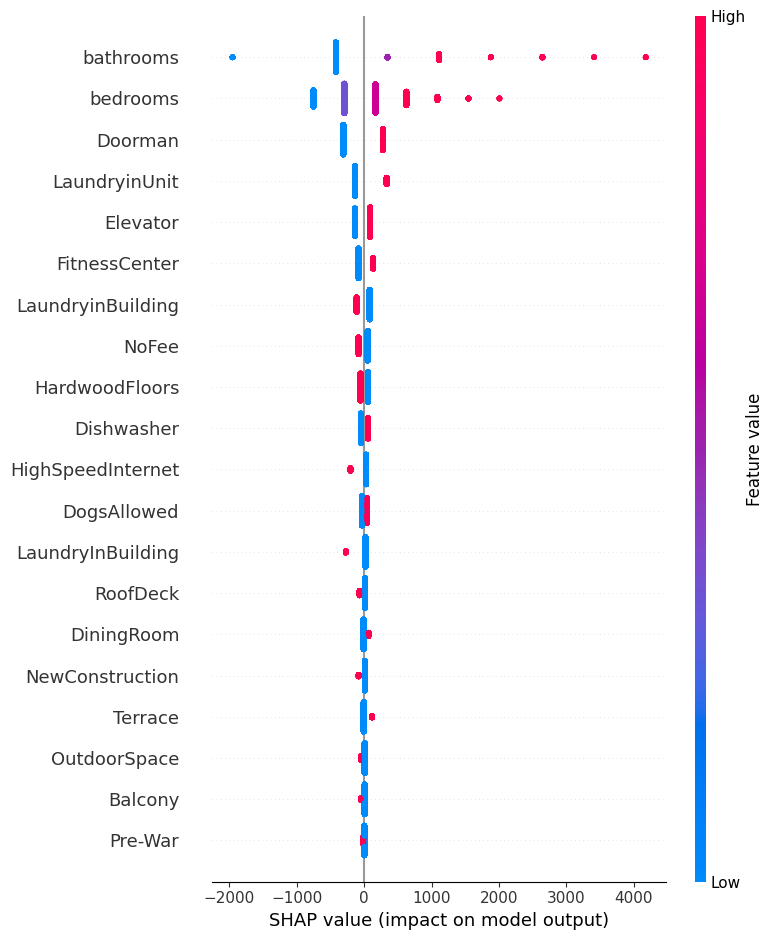

In [ ]:
shap.summary_plot(shap_val_values, xval_s)

In [263]:
imp

bathrooms            583.579365
bedrooms             421.905495
Doorman              296.088466
LaundryinUnit        170.889223
Elevator             112.754563
FitnessCenter         97.449152
LaundryinBuilding     91.549735
NoFee                 63.474011
HardwoodFloors        56.406858
Dishwasher            52.789521
HighSpeedInternet     42.610192
DogsAllowed           37.416021
LaundryInBuilding     28.557924
RoofDeck              20.341139
DiningRoom            15.633920
NewConstruction       13.143753
Terrace               12.366672
OutdoorSpace          11.253830
Balcony                9.159058
Pre-War                3.890899
SwimmingPool           0.000000
CatsAllowed            0.000000
dtype: float64

In [ ]:
top10_shap = imp.head(10).index.tolist()
top10_shap


['bathrooms',
 'bedrooms',
 'Doorman',
 'LaundryinUnit',
 'Elevator',
 'FitnessCenter',
 'LaundryinBuilding',
 'NoFee',
 'HardwoodFloors',
 'Dishwasher']

In [ ]:
xtrain_10_shap,xval_10_shap,xtest_10_shap = xtrain[top10_shap],x_val[top10_shap],xtest[top10_shap]
s_shap = StandardScaler()
xtrain_10_shap_s = s_shap.fit_transform(xtrain_10_shap)
xval_10_shap_s = s_shap.transform(xval_10_shap)
xtest_10_shap_s = s_shap.transform(xtest_10_shap)

In [ ]:
alphas = np.logspace(0.99,1.1,1000)


In [ ]:

best = None
for alpha in alphas:
    model = Lasso(alpha=alpha,max_iter=10000)
    model.fit(xtrain_10_shap_s,ytrain)
    y_pred = model.predict(xval_10_shap_s)

    mae = mean_absolute_error(y_val,y_pred)
    if best is None or best[1]>mae:
        best = (alpha,mae)


In [ ]:
best

(np.float64(9.772372209558107), 706.8792917784945)

In [ ]:
best_lasso_10_shap = Lasso(alpha=best[0])
best_lasso_10_shap.fit(xtrain_10_shap_s,ytrain)
y_pred_lasso_10_shap = best_lasso_10_shap.predict(xtest_10_shap_s)


In [ ]:
mae_lasso_10_shap = mean_absolute_error(ytest,y_pred_lasso_10_shap)
rmse_lasso_10_shap = root_mean_squared_error(ytest,y_pred_lasso_10_shap)
r2_lasso_10_shap = r2_score(ytest,y_pred_lasso_10_shap)
print(mae_lasso_10_shap,rmse_lasso_10_shap,r2_lasso_10_shap)


724.4669397640077 1042.023161381441 0.5656632855762429


#### 6.6 Compare the quality of these methods for different aspects — speed, metrics and stability.





In [ ]:
%%timeit
best_lasso = Lasso(alpha=6.309573444801933)
best_lasso.fit(xtrain_s,ytrain)
y_pred_lasso = best_lasso.predict(xtest_s)
features_weights = dict(zip(xtrain_s.columns, best_lasso.coef_))
sorted_features = sorted(features_weights.items(), key=lambda x: abs(x[1]), reverse=True)
top10_features = [f for f, w in sorted_features[:10]]


2.79 ms ± 173 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
t = nan_cor_selection(xtrain_s,ytrain,max_nan_ratio=0.5,top_k=10)

8.8 ms ± 157 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
permutation_importance(xval_s,yval,best_lasso)

60.5 ms ± 719 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
shap_val_values = explainer.shap_values(xval_s)
imp = pd.Series(np.abs(shap_val_values).mean(axis=0), index=xval_s.columns)
imp = imp.sort_values(ascending=False)
top10_shap = imp.head(10).index.tolist()



199 μs ± 3.32 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
print(f"Lasso feature selection:                 MAE - {mae_lasso_10}, RMSE - {rmse_lasso_10}, R2 - {r2_lasso_10}, time ~ 2.58 ms ± 33.6")
print(f"Pearson's correlation feature selection: MAE - {mae_lasso_f10}, RMSE - {rmse_lasso_f10}, R2 - {r2_lasso_f10}, time ~ 8.29 ms ± 147" )
print(f"Permutation importance feature selection:MAE - {mae_lasso_pi10}, RMSE - {rmse_lasso_pi10}, R2 - {r2_lasso_pi10}, time ~ 60.5 ms ± 4.14")
print(f"SHAP feature selection:                  MAE - {mae_lasso_10_shap}, RMSE - {rmse_lasso_10_shap}, R2 - {r2_lasso_10_shap}, time ~ 193 μs ± 33.1 μs")

Lasso feature selection:                 MAE - 725.2376567496437, RMSE - 1040.156766083042, R2 - 0.5672177961644181, time ~ 2.58 ms ± 33.6
Pearson's correlation feature selection: MAE - 729.2579584173212, RMSE - 1047.0235459386113, R2 - 0.5614847572305601, time ~ 8.29 ms ± 147
Permutation importance feature selection:MAE - 725.9853759745773, RMSE - 1042.4122579697168, R2 - 0.5653388580730405, time ~ 60.5 ms ± 4.14
SHAP feature selection:                  MAE - 724.4669397640077, RMSE - 1042.023161381441, R2 - 0.5656632855762429, time ~ 193 μs ± 33.1 μs


### 7. Hyperparameter optimization

#### 7.1 Implement grid search and random search methods for alpha and l1_ratio for sklearn's ElasticNet model.

In [ ]:
def elasticnet_gridsearch(X, y, alphas: Sequence, l1_ratios: Sequence,
                          test_size: float = 0.2, random_state: int = 21):
    if not (0.0 < float(test_size) < 1.0):
        raise ValueError("test_size must be in (0,1)")
    X_train, X_val, y_train, y_val = train_test_split21(X, y, test_size=test_size, random_state=random_state)
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train,y_train)
    X_val_scaled = sc.transform(X_val)
    best_score, best_params, best_model = np.inf, None, None
    for alpha in alphas:
        for l1 in l1_ratios:
            model = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=21, max_iter=10000)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            mae = mean_absolute_error(y_val, y_pred)
            if mae < best_score:
                best_score, best_params, best_model = mae, {"alpha": alpha, "l1_ratio": l1}, model
    return best_params, best_score, best_model

In [ ]:

def elasticnet_randomsearch(
    X, y,
    alphas_logspace: tuple,        
    l1_ratios_linspace: tuple,     
    n_iter: int,
    test_size: float = 0.2,
    random_state: int = 21
):

    if not (0.0 < float(test_size) < 1.0):
        raise ValueError("test_size must be in (0,1)")
    if len(alphas_logspace) != 2 or alphas_logspace[0] >= alphas_logspace[1]:
        raise ValueError("alphas_logspace should be (low_exp, high_exp) with low<high")
    if len(l1_ratios_linspace) != 2 or not (0.0 <= l1_ratios_linspace[0] < l1_ratios_linspace[1] <= 1.0):
        raise ValueError("l1_ratios_linspace should satisfy 0 <= low < high <= 1")
    if n_iter < 1:
        raise ValueError("n_iter must be >= 1")
    

    X_train, X_val, y_train, y_val = train_test_split21(X, y, test_size=test_size, random_state=random_state)
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train,y_train)
    X_val_scaled = sc.transform(X_val)

    rng = np.random.RandomState(random_state)

    best_score = float("inf")
    best_params = None

    exp_lo, exp_hi = alphas_logspace
    l1_lo, l1_hi   = l1_ratios_linspace

    for _ in range(n_iter):

        alpha = 10 ** rng.uniform(exp_lo, exp_hi)   # log-uniform
        l1    = rng.uniform(l1_lo, l1_hi)           # uniform

        model = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=21, max_iter=10000)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        mae = mean_absolute_error(y_val, y_pred)

        if mae < best_score:
            best_score  = mae
            best_params = {"alpha": float(alpha), "l1_ratio": float(l1)}
            best_model  = model

    return best_params, best_score, best_model


#### 7.2 Find the best combination of model hyperparameters

In [ ]:

X_raw_train = X_train.drop(columns='created')
X_raw_test  = X_test.drop(columns='created')

alphas = np.logspace(0, 1, 100)
l1_ratios = np.linspace(0, 1, 100)

best_params, best_score, _ = elasticnet_gridsearch(X_raw_train, y_train, alphas, l1_ratios)
best_rand_params, best_rand_score, _ = elasticnet_randomsearch(X_raw_train, y_train,
                                                               alphas_logspace=(-3, 5),
                                                               l1_ratios_linspace=(0, 1),
                                                               n_iter=100)
print(best_params, best_score)
print(best_rand_params, best_rand_score)


{'alpha': np.float64(7.220809018385466), 'l1_ratio': np.float64(1.0)} 709.1792366653906
{'alpha': 0.07074545099643877, 'l1_ratio': 0.5904577635433566} 709.3782656691324


#### 7.3 Fit the resulting model

In [ ]:
best_alpha = best_params["alpha"]
best_l1    = best_params["l1_ratio"]


final_pipe = Pipeline([
    ("sc", StandardScaler()),
    ("en", ElasticNet(alpha=best_alpha, l1_ratio=best_l1, random_state=21, max_iter=10000)),
])


X_tr_final = X_train.drop(columns="created")
final_pipe.fit(X_tr_final, y_train)


,steps,"[('sc', ...), ('en', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(7.220809018385466)
,l1_ratio,np.float64(1.0)
,fit_intercept,True
,precompute,False


#### 7.4 Import optuna and configure the same experiment with ElasticNet.

In [ ]:

def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
    l1_ratio = trial.suggest_uniform("l1_ratio", 0.0, 1.0)


    X_train, X_val, y_train, y_val = train_test_split21(X, y, test_size=0.2, random_state=21)
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train,y_train)
    X_val_scaled = sc.transform(X_val)


    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=21, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    mae = mean_absolute_error(y_val, y_pred)
    return mae
X=X_train.drop(columns='created')
y=y_train
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=21)


In [ ]:

study = optuna.create_study(direction="minimize",sampler=sampler)
study.optimize(objective, n_trials=100,show_progress_bar=True)

print("Best params:", study.best_params)
print("Best MAE:", study.best_value)

  0%|          | 0/100 [00:00<?, ?it/s]

Best params: {'alpha': 0.33201339593981416, 'l1_ratio': 0.9101509044501483}
Best MAE: 709.3753028578765


#### 7.5 Estimate metrics and compare approaches

In [ ]:
alpha_gridsearch, l1_ratio_gridsearch = best_params.values()
alpha_randomsearch, l1_randomsearch = best_rand_params.values()
alpha_optuna, l1_optuna = study.best_params.values()


In [ ]:
alpha_grid, l1_grid = best_params["alpha"], best_params["l1_ratio"]
alpha_rand, l1_rand = best_rand_params["alpha"], best_rand_params["l1_ratio"]
alpha_opt,  l1_opt  = study.best_params["alpha"], study.best_params["l1_ratio"]

def make_pipe(a, l1):
    return Pipeline([
        ('sc', StandardScaler()),
        ('en', ElasticNet(alpha=a, l1_ratio=l1, random_state=21, max_iter=10000))
    ])

pipe_gs     = make_pipe(alpha_grid, l1_grid).fit(X_raw_train, y_train)
pipe_rs     = make_pipe(alpha_rand, l1_rand).fit(X_raw_train, y_train)
pipe_optuna = make_pipe(alpha_opt,  l1_opt ).fit(X_raw_train, y_train)

y_pred_gs     = pipe_gs.predict(X_raw_test)
y_pred_rs     = pipe_rs.predict(X_raw_test)
y_pred_optuna = pipe_optuna.predict(X_raw_test)

mae_gs  = mean_absolute_error(y_test, y_pred_gs)
rmse_gs = root_mean_squared_error(y_test, y_pred_gs)
r2_gs   = r2_score(y_test, y_pred_gs)

mae_rs  = mean_absolute_error(y_test, y_pred_rs)
rmse_rs = root_mean_squared_error(y_test, y_pred_rs)
r2_rs   = r2_score(y_test, y_pred_rs)

mae_optuna  = mean_absolute_error(y_test, y_pred_optuna)
rmse_optuna = root_mean_squared_error(y_test, y_pred_optuna)
r2_optuna   = r2_score(y_test, y_pred_optuna)


In [ ]:
print(f'GridSearch params Elastic net   MAE - {mae_gs}, RMSE - {rmse_gs}, R2 - {r2_gs}, iters = {10000}, time ~ 50.4 s ± 4.53 s ')
print(f'RandomSearch params Elastic net MAE - {mae_rs}, RMSE - {rmse_rs}, R2 - {r2_rs}, iters = {100}, time - 559 ms ± 28.2 ms ')
print(f'Optuna params Elastic net       MAE - {mae_optuna}, RMSE - {rmse_optuna}, R2 - {r2_optuna}, iters = {100}, time - 1.2 s ± 64.6')

GridSearch params Elastic net   MAE - 712.3433122135002, RMSE - 1214.3165506529424, R2 - 0.4044888809156372, iters = 10000, time ~ 50.4 s ± 4.53 s 
RandomSearch params Elastic net MAE - 712.3789738421818, RMSE - 1205.9702202151989, R2 - 0.41264697008537377, iters = 100, time - 559 ms ± 28.2 ms 
Optuna params Elastic net       MAE - 712.3455823679253, RMSE - 1205.7750487491855, R2 - 0.4128370664474519, iters = 100, time - 1.2 s ± 64.6


#### Все три метода дают близкие результаты по MAE (~712). Однако:

##### GridSearch достигает лучшего MAE (712.343) но требует ~10 000 итераций и ~50 с, что делает его наименее эффективным.

##### RandomSearch достигает  MAE (712.379)  всего за ~100 итераций и <1 с.

##### Optuna показывает сопоставимое качество (MAE 712.3456) за ~100 итераций, но дольше по времени (~1.2 с).

##### Таким образом, по метрике MAE и скорости наиболее эффективным является RandomSearch, тогда как Optuna предпочтительнее, если важна стабильность и воспроизводимость поиска.

#### 7.6 Run optuna on one of the cross-validation schemes.

In [ ]:

def objective_cv(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 10.0, log=True)
    l1    = trial.suggest_float("l1_ratio", 0.0, 1.0)
    tss = TimeSeriesSplit21(k=5, date_field=X_cv['created'])
    maes = []
    for tr_idx, va_idx in tss.split(X_cv):
        X_tr = X_cv.drop(columns='created').loc[tr_idx]
        X_val = X_cv.drop(columns='created').loc[va_idx]
        y_tr = y_cv.loc[tr_idx]
        y_val = y_cv.loc[va_idx]

        pipe = Pipeline([
        ('sc', StandardScaler()),
        ('en', ElasticNet(alpha=alpha, l1_ratio=l1, random_state=21, max_iter=10000))])
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_val)
        maes.append(mean_absolute_error(y_val, y_pred))
    return float(np.mean(maes))
X_cv = X_train
y_cv = y_train
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective_cv, n_trials=1000)
print(study.best_params, study.best_value)


{'alpha': 5.609542239884382, 'l1_ratio': 0.9986295970809719} 707.9725026417448


In [ ]:
alpha_optuna_cv, l1_optuna_cv = study.best_params.values()

In [ ]:
final_pipe_cv = Pipeline([
    ('sc', StandardScaler()),
    ('en', ElasticNet(alpha=alpha_optuna_cv, l1_ratio=l1_optuna_cv, random_state=21, max_iter=10000))
])
final_pipe_cv.fit(X_raw_train, y_train)
y_pred_optuna_cv = final_pipe_cv.predict(X_raw_test)

mae_optuna_cv  = mean_absolute_error(y_test, y_pred_optuna_cv)
rmse_optuna_cv = root_mean_squared_error(y_test, y_pred_optuna_cv)
r2_optuna_cv   = r2_score(y_test, y_pred_optuna_cv)


In [ ]:
print(f'Optuna_cv params Elastic net       MAE - {mae_optuna_cv}, RMSE - {rmse_optuna_cv}, R2 - {r2_optuna_cv}')
print(f'GridSearch params Elastic net   MAE - {mae_gs}, RMSE - {rmse_gs}, R2 - {r2_gs}, iters = {10000}, time ~ 50.4 s ± 4.53 s ')
print(f'RandomSearch params Elastic net MAE - {mae_rs}, RMSE - {rmse_rs}, R2 - {r2_rs}, iters = {100}, time - 559 ms ± 28.2 ms ')
print(f'Optuna params Elastic net       MAE - {mae_optuna}, RMSE - {rmse_optuna}, R2 - {r2_optuna}, iters = {100}, time - 1.2 s ± 64.6')

Optuna_cv params Elastic net       MAE - 712.2679969024142, RMSE - 1211.9798643824086, R2 - 0.4067785372904281
GridSearch params Elastic net   MAE - 712.3433122135002, RMSE - 1214.3165506529424, R2 - 0.4044888809156372, iters = 10000, time ~ 50.4 s ± 4.53 s 
RandomSearch params Elastic net MAE - 712.3789738421818, RMSE - 1205.9702202151989, R2 - 0.41264697008537377, iters = 100, time - 559 ms ± 28.2 ms 
Optuna params Elastic net       MAE - 712.3455823679253, RMSE - 1205.7750487491855, R2 - 0.4128370664474519, iters = 100, time - 1.2 s ± 64.6
